# **Walker SAC**

### **Imports**

In [1]:
from rlkit.util import MultiVersionCheckpointer, Checkpointer, Logger, SimpleMetricModule, Stopwatch
from config import *

import os
import pandas as pd
import math
import matplotlib.pyplot as plt
from env import create_env

# Import Torch
import torch
from torch import nn
from torch import optim
from torchinfo import summary

# Models and Loss
from rlkit.models import MLP, CatWrapper
from tensordict.nn import TensorDictModule
from torchrl.modules import ProbabilisticActor, TanhNormal
from tensordict.nn.distributions import NormalParamExtractor

# Data
from tensordict import TensorDict
from torchrl.collectors import SyncDataCollector, MultiaSyncDataCollector, aSyncDataCollector
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

# Util
from torchrl.objectives import SACLoss, SoftUpdate, ValueEstimators

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_type = "cuda" if str(device).startswith("cuda") else "cpu"
amp_dtype   = torch.float16 if device_type == "cuda" else torch.float32
device, amp_dtype

(device(type='cpu'), torch.float32)

## Models

In [2]:
def create_policy(model_config):
    model_config = model_config.copy()
    model_config["out_features"] *= 2
    model = MLP(**model_config)

    model = nn.Sequential(
        model,
        NormalParamExtractor()
    )
    model = TensorDictModule(model, in_keys=["observation"], out_keys=["loc", "scale"])
    
    policy = ProbabilisticActor(
        module=model,  
        distribution_class=TanhNormal,

        in_keys=["loc", "scale"],
        out_keys=["action"],

        return_log_prob=True,
        log_prob_key="log_prob",
        cache_dist=True,
    )

    return policy

def create_qvalue(model_config):
    # Remove out_features from config
    model_config = model_config.copy()
    model_config["in_features"] = model_config["in_features"] + model_config["out_features"]
    model_config["out_features"] = 1

    model = MLP(**model_config)
    model = CatWrapper(model)
    qvalue = TensorDictModule(model, in_keys=["observation", "action"], out_keys=["state_action_value"])
    return qvalue

In [3]:
policy = create_policy(MODEL_CONFIG)
qvalue = create_qvalue(MODEL_CONFIG)

In [4]:
samples = (torch.randn(1, MODEL_CONFIG["in_features"]), torch.randn(1, MODEL_CONFIG["out_features"]))
summary(qvalue, input_data=samples)

Layer (type:depth-idx)                        Output Shape              Param #
TensorDictModule                              [1, 1]                    --
├─CatWrapper: 1-1                             [1, 1]                    --
│    └─MLP: 2-1                               [1, 1]                    --
│    │    └─Linear: 3-1                       [1, 128]                  36,224
│    │    └─ModuleList: 3-2                   --                        393,216
│    │    └─Sequential: 3-3                   [1, 1]                    257
Total params: 516,993
Trainable params: 516,993
Non-trainable params: 0
Total mult-adds (M): 0.43
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.72
Estimated Total Size (MB): 1.74

In [5]:
samples = torch.randn(1 ,MODEL_CONFIG["in_features"])
summary(policy.module[0], input_data=samples)

Layer (type:depth-idx)                        Output Shape              Param #
TensorDictModule                              [1, 39]                   --
├─Sequential: 1-1                             [1, 39]                   --
│    └─MLP: 2-1                               [1, 78]                   --
│    │    └─Linear: 3-1                       [1, 128]                  31,232
│    │    └─ModuleList: 3-2                   --                        393,216
│    │    └─Sequential: 3-3                   [1, 78]                   10,190
│    └─NormalParamExtractor: 2-2              [1, 39]                   --
│    │    └─biased_softplus: 3-4              [1, 39]                   --
Total params: 521,934
Trainable params: 521,934
Non-trainable params: 0
Total mult-adds (M): 0.43
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 1.74
Estimated Total Size (MB): 1.76

In [6]:
# loss_module = SACLoss(
#     actor_network=policy, qvalue_network=qvalue, value_network=None,
#     num_qvalue_nets=2,
#     alpha_init=0.1, fixed_alpha=True, 
#     delay_actor=False, delay_qvalue=True
# )
# target_updater = SoftUpdate(loss_module, tau=0.005)

In [7]:
# try: env.close()
# except: pass
# env = create_env(graphics=False, time_scale=10)

# with torch.no_grad():
#     data = env.rollout(100, policy=policy, break_when_any_done=False)
# data, loss_module(data)

## Train

### Config

In [8]:
TIME_SCALE = 5

In [103]:
WORKERS = os.cpu_count() // 2
TIMESTEPS = 100_000_000
BUFFER_SIZE = 3_000_000
BATCH_SIZE = 256

# ENTROPY_TARGET = 1e-3
ENTROPY_COEF = 3e-4
# print("Entropy Target:", ENTROPY_TARGET)
GAMMA = 0.99
TAU = 0.005

LR = 1e-5

TRAIN_STEPS = 512
ENV_STEPS = 1000 * WORKERS
# Steps = N*K, train_iters = K. K helps with buffering async collected data with less stalls

CKPT_EVAL_INTERVAL = 100
EVAL_STEPS = 1000

In [104]:
NAME = 'run0'
CONTINUE = True

### State

In [105]:
policy = create_policy(MODEL_CONFIG).to(device)
qvalue = create_qvalue(MODEL_CONFIG).to(device)

loss_module = SACLoss(
    actor_network=policy, qvalue_network=qvalue, value_network=None,
    num_qvalue_nets=2,
    alpha_init=ENTROPY_COEF, fixed_alpha=True,
    # target_entropy=ENTROPY_TARGET, fixed_alpha=False,
    delay_actor=False, delay_qvalue=True
)
loss_module.make_value_estimator(gamma=GAMMA)
target_updater = SoftUpdate(loss_module, tau=TAU)

optimizer = optim.Adam(loss_module.parameters(), lr=LR)

replay_buffer = TensorDictReplayBuffer(
    storage = LazyMemmapStorage(max_size=BUFFER_SIZE, ndim=2),
    batch_size = BATCH_SIZE,
)

In [106]:
logger = Logger(keys = LOG_KEYS, log_path=LOG_PATH, name=NAME)
checkpointer = MultiVersionCheckpointer(ckpt_path=CKPT_PATH, name=NAME, metric_key="score", levels=10, base_interval=10, interval_scale=1.75)

# Continue/Reset
start_timestep = 0
if not CONTINUE:
    logger.reset()
    checkpointer.reset()
else:
    checkpoint = checkpointer.load_progress()
    if checkpoint:
        start_timestep = checkpoint['timestep']
        print(f"Found checkpoint at timestep: {start_timestep}")
        logger.revert("timestep", start_timestep)
        loss_module.load_state_dict(checkpoint["loss_module"], strict=False)
    else:
        print("Checkpoint not found, restarting")
        logger.reset()
loss_module.log_alpha = torch.tensor(math.log(ENTROPY_COEF), device=device)
loss_module._value_estimator.gamma = torch.tensor(GAMMA, device=device)

Found checkpoint at timestep: 72555000.0


In [107]:
collector = MultiaSyncDataCollector(
    [lambda: create_env(graphics=False, time_scale=TIME_SCALE)]*WORKERS, policy, 
    frames_per_batch = ENV_STEPS, 
    total_frames = TIMESTEPS - start_timestep, 
    env_device="cpu", device=device, storing_device="cpu",
    reset_at_each_iter=False,
)
short_watch, long_watch = Stopwatch(), Stopwatch()
metric_module = SimpleMetricModule(mode="approx")

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/collectors/collectors.py:2137: UserWarning: total_frames (27445000.0) is not exactly divisible by frames_per_batch (7000). This means 2000.0 additional frames will be collected. To silence this message, set the environment variable RL_WARNINGS to False.
  warnings.warn(


[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
[UnityMemory] Configuration Parameters - Can be set up in boot

In [108]:
try: eval_env.close()
except: pass
eval_env = create_env(graphics=False, time_scale=TIME_SCALE)
short_watch.start(); long_watch.start()
for i, data in enumerate(collector):
    # 1. Extend
    replay_buffer.extend(data)
    logger.add({"collect_wait_time": short_watch.end(), "timestep": ENV_STEPS})
    avg_reward = data["next", "reward"].mean().cpu().item()
    score = (avg_reward / BENCH_AVG_REWARD) * 100
    logger.acc({"score": score})

    # 2. Train Loop
    short_watch.start()
    for j in range(TRAIN_STEPS):
        batch = replay_buffer.sample().to(device)

        # 1. SAC Loss
        loss_data = loss_module(batch)
        loss = loss_data["loss_actor"] + loss_data["loss_qvalue"] + loss_data["loss_alpha"]
        
        # 2. Update
        optimizer.zero_grad(); loss.backward()
        optimizer.step(); target_updater.step()

        # 3. Log Metrics
        logger.acc({
            "policy_loss":  loss_data["loss_actor"].detach().cpu().item(),
            "qvalue_loss":  loss_data["loss_qvalue"].detach().cpu().item(),
            "entropy":      loss_data["entropy"].detach().cpu().item(),
            "td_error":     batch["td_error"].detach().mean().cpu().item(),
            "alpha":        loss_data["alpha"].detach().mean().cpu().item(),
        }, mode='ema')
    logger.add({"train_time": short_watch.end()})


    # 3. Sync Policy
    collector.update_policy_weights_()

    # 4. Checkpoint and eval
    if (i+1) % CKPT_EVAL_INTERVAL == 0:
        eval_env.reset()
        with torch.no_grad():
            data = eval_env.rollout(EVAL_STEPS, policy=policy, break_when_any_done=False, auto_cast_to_device=True)
        metrics = metric_module(data)
        metrics["eval_entropy"] = metrics["entropy"]
        del metrics["entropy"]
        logger.acc(metrics)
        checkpointer.save_progress(state_obj={
            "timestep": logger.last()["timestep"],
            "loss_module": loss_module.state_dict(),
        })
    else:
        logger.add({key: 0 for key in ["return", "episode_length", "eval_entropy"]})

    # 5. Log
    logger.add({"time": long_watch.end()})
    short_watch.start(); long_watch.start()
    logger.next(print_row=True)
collector.shutdown()


[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/transforms/transforms.py:587: FutureWarning: The key 'continuous_action' is unaccounted for by the transform (expected keys ['VectorSensor_size243', 'done', 'terminated', 'truncated', 'group_reward', 'reward']). Every new entry in the tensordict resulting from a call to a transform must be registered in the specs for torchrl rollouts to be consistently built. Make sure transform_output_spec/transform_observation_spec/... is coded correctly. This warning will trigger a KeyError in v0.9, make sure to adapt your code accordingly.
  warnings.warn(


Thread 0x16d727000 may have been prematurely finalized
Setting up 7 worker threads for Enlighten.
Thread 0x16c213000 may have been prematurely finalized
Memory Statistics:
[ALLOC_TEMP_TLS] TLS Allocator
  StackAllocators : 
    [ALLOC_TEMP_MAIN]
      Peak usage frame count: [1.0 KB-2.0 KB]: 93 frames, [2.0 MB-4.0 MB]: 1 frames
      Initial Block Size 4.0 MB
      Current Block Size 4.0 MB
      Peak Allocated Bytes 2.1 MB
      Overflow Count 0
    [ALLOC_TEMP_Background Job.worker 4]
      Initial Block Size 32.0 KB
      Current Block Size 32.0 KB
      Peak Allocated Bytes 0 B
      Overflow Count 0
    [ALLOC_TEMP_Loading.PreloadManager]
      Initial Block Size 256.0 KB
      Current Block Size 256.0 KB
      Peak Allocated Bytes 92.6 KB
      Overflow Count 5
    [ALLOC_TEMP_Background Job.worker 3]
      Initial Block Size 32.0 KB
      Current Block Size 32.0 KB
      Peak Allocated Bytes 0 B
      Overflow Count 0
    [ALLOC_TEMP_Background Job.worker 11]
      Initial Block

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


         timestep          time  collect_wait_time     train_time      score  \
10464  73255000.0  258022.30937         244.126044  255471.416572  62.872991   

       policy_loss  qvalue_loss   alpha   entropy  td_error    return  \
10464     -2.00249     0.001786  0.0003 -1.872646  0.017592  25.69932   

       episode_length  eval_entropy  
10464          1000.0     -9.310139  
         timestep           time  collect_wait_time     train_time      score  \
10465  73262000.0  258048.187371          244.14238  255497.278168  77.181801   

       policy_loss  qvalue_loss   alpha   entropy  td_error    return  \
10465    -1.999954     0.001722  0.0003 -1.826521  0.017894  25.69932   

       episode_length  eval_entropy  
10465          1000.0     -9.310139  
         timestep           time  collect_wait_time     train_time      score  \
10466  73269000.0  258073.689634         244.157822  255522.764909  92.083149   

       policy_loss  qvalue_loss   alpha   entropy  td_error    retu

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


         timestep           time  collect_wait_time     train_time      score  \
10564  73955000.0  260285.914773         245.606105  257716.478584  89.777969   

       policy_loss  qvalue_loss   alpha   entropy  td_error     return  \
10564    -2.030131     0.002816  0.0003 -1.776932  0.020598  28.165409   

       episode_length  eval_entropy  
10564          1000.0     -8.101072  
         timestep           time  collect_wait_time     train_time      score  \
10565  73962000.0  260308.865483         245.620464  257739.414878  96.945196   

       policy_loss  qvalue_loss   alpha   entropy  td_error     return  \
10565      -2.0422     0.002173  0.0003 -2.688835   0.01976  28.165409   

       episode_length  eval_entropy  
10565          1000.0     -8.101072  
         timestep           time  collect_wait_time     train_time      score  \
10566  73969000.0  260331.022698         245.636678  257761.555815  75.425409   

       policy_loss  qvalue_loss   alpha   entropy  td_error  

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


         timestep           time  collect_wait_time     train_time      score  \
10664  74655000.0  262559.037558         247.207226  259971.114903  63.108996   

       policy_loss  qvalue_loss   alpha   entropy  td_error     return  \
10664    -2.086335     0.002004  0.0003 -1.399882  0.019545  21.006897   

       episode_length  eval_entropy  
10664          1000.0     -4.032137  
         timestep           time  collect_wait_time     train_time      score  \
10665  74662000.0  262583.617856         247.224065  259995.678299  77.339806   

       policy_loss  qvalue_loss   alpha   entropy  td_error     return  \
10665    -2.089674     0.002685  0.0003 -1.145194   0.01988  21.006897   

       episode_length  eval_entropy  
10665          1000.0     -4.032137  
         timestep           time  collect_wait_time     train_time      score  \
10666  74669000.0  262608.354114         247.240059  260020.398506  82.424119   

       policy_loss  qvalue_loss   alpha   entropy  td_error  

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


         timestep          time  collect_wait_time     train_time      score  \
10764  75355000.0  264793.65785         248.790795  262187.337307  91.279648   

       policy_loss  qvalue_loss   alpha   entropy  td_error     return  \
10764    -2.120149     0.002007  0.0003  0.909243  0.017982  21.788311   

       episode_length  eval_entropy  
10764          1000.0     -6.059991  
         timestep           time  collect_wait_time     train_time      score  \
10765  75362000.0  264817.761899          248.80718  262211.424883  92.145331   

       policy_loss  qvalue_loss   alpha   entropy  td_error     return  \
10765    -2.118616     0.002673  0.0003  0.526887  0.018347  21.788311   

       episode_length  eval_entropy  
10765          1000.0     -6.059991  
         timestep           time  collect_wait_time     train_time     score  \
10766  75369000.0  264842.461821         248.823254  262236.108672  82.26081   

       policy_loss  qvalue_loss   alpha   entropy  td_error     r

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


         timestep           time  collect_wait_time     train_time      score  \
10864  76055000.0  267064.336575         250.101864  264439.843718  89.961119   

       policy_loss  qvalue_loss   alpha   entropy  td_error     return  \
10864    -2.160132     0.002671  0.0003  1.408613  0.018346  20.429419   

       episode_length  eval_entropy  
10864          1000.0      -8.31724  
         timestep           time  collect_wait_time     train_time      score  \
10865  76062000.0  267088.672255         250.112555  264464.168648  96.936494   

       policy_loss  qvalue_loss   alpha   entropy  td_error     return  \
10865    -2.169782     0.002703  0.0003  1.478777  0.019269  20.429419   

       episode_length  eval_entropy  
10865          1000.0      -8.31724  
         timestep           time  collect_wait_time     train_time      score  \
10866  76069000.0  267112.546241         250.122616  264488.032514  65.221027   

       policy_loss  qvalue_loss   alpha   entropy  td_error  

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


         timestep           time  collect_wait_time     train_time      score  \
10964  76755000.0  269293.655506         251.121859  266651.893766  94.020404   

       policy_loss  qvalue_loss   alpha  entropy  td_error    return  \
10964    -2.187637     0.002888  0.0003  2.17496  0.018902  26.01626   

       episode_length  eval_entropy  
10964          1000.0     -5.007243  
         timestep           time  collect_wait_time     train_time      score  \
10965  76762000.0  269318.323634         251.131862  266676.551831  87.689482   

       policy_loss  qvalue_loss   alpha   entropy  td_error    return  \
10965    -2.179703     0.002712  0.0003  2.483315  0.018502  26.01626   

       episode_length  eval_entropy  
10965          1000.0     -5.007243  
         timestep           time  collect_wait_time     train_time      score  \
10966  76769000.0  269341.909246         251.149847  266700.119402  85.325472   

       policy_loss  qvalue_loss   alpha   entropy  td_error    retu

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


         timestep           time  collect_wait_time     train_time      score  \
11064  77455000.0  271546.363961         252.173189  268886.821002  71.324147   

       policy_loss  qvalue_loss   alpha  entropy  td_error     return  \
11064    -2.184573     0.002465  0.0003  2.44112  0.018641  27.059631   

       episode_length  eval_entropy  
11064          1000.0     -6.665394  
         timestep           time  collect_wait_time    train_time      score  \
11065  77462000.0  271570.228368         252.184249  268910.67429  89.648083   

       policy_loss  qvalue_loss   alpha   entropy  td_error     return  \
11065    -2.176816     0.003445  0.0003  2.060567   0.01946  27.059631   

       episode_length  eval_entropy  
11065          1000.0     -6.665394  
         timestep           time  collect_wait_time     train_time      score  \
11066  77469000.0  271594.601158         252.195733  268935.035537  92.251837   

       policy_loss  qvalue_loss   alpha   entropy  td_error     r

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


         timestep           time  collect_wait_time     train_time      score  \
11164  78155000.0  273772.640777         253.224983  271095.471171  81.336975   

       policy_loss  qvalue_loss   alpha   entropy  td_error     return  \
11164    -2.187683     0.002937  0.0003  1.323189  0.019282  18.521315   

       episode_length  eval_entropy  
11164          1000.0     -3.168355  
         timestep           time  collect_wait_time     train_time      score  \
11165  78162000.0  273797.132743         253.237057  271119.951003  80.505826   

       policy_loss  qvalue_loss   alpha   entropy  td_error     return  \
11165    -2.178858     0.002672  0.0003  0.989275  0.019129  18.521315   

       episode_length  eval_entropy  
11165          1000.0     -3.168355  
         timestep           time  collect_wait_time    train_time      score  \
11166  78169000.0  273820.928405         253.246714  271143.73696  72.908431   

       policy_loss  qvalue_loss   alpha   entropy  td_error    

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


         timestep           time  collect_wait_time     train_time      score  \
11264  78855000.0  276095.059821         254.277465  273399.954104  84.813543   

       policy_loss  qvalue_loss   alpha   entropy  td_error    return  \
11264     -2.17626     0.002496  0.0003  1.692481  0.018139  28.71883   

       episode_length  eval_entropy  
11264          1000.0     -5.503853  
         timestep           time  collect_wait_time     train_time      score  \
11265  78862000.0  276117.930086          254.28844  273422.813299  72.040409   

       policy_loss  qvalue_loss   alpha   entropy  td_error    return  \
11265    -2.197727     0.003657  0.0003  1.140704  0.020009  28.71883   

       episode_length  eval_entropy  
11265          1000.0     -5.503853  
         timestep           time  collect_wait_time     train_time      score  \
11266  78869000.0  276139.370929         254.297797  273444.244703  90.076782   

       policy_loss  qvalue_loss   alpha   entropy  td_error    re

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


         timestep          time  collect_wait_time     train_time      score  \
11364  79555000.0  278458.67047         255.289186  275745.871405  75.316258   

       policy_loss  qvalue_loss   alpha   entropy  td_error     return  \
11364     -2.18099     0.004015  0.0003  0.900252  0.020834  25.857162   

       episode_length  eval_entropy  
11364          1000.0     -6.894948  
         timestep           time  collect_wait_time     train_time  \
11365  79562000.0  278481.871277         255.299803  275769.061535   

            score  policy_loss  qvalue_loss   alpha   entropy  td_error  \
11365  107.103519     -2.20118     0.002417  0.0003  0.948538  0.019041   

          return  episode_length  eval_entropy  
11365  25.857162          1000.0     -6.894948  
         timestep           time  collect_wait_time     train_time  \
11366  79569000.0  278503.320611         255.306787  275790.503834   

            score  policy_loss  qvalue_loss   alpha   entropy  td_error  \
11366  1

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


         timestep           time  collect_wait_time     train_time      score  \
11464  80255000.0  280670.969086         256.239143  277940.816287  68.327732   

       policy_loss  qvalue_loss   alpha   entropy  td_error     return  \
11464     -2.18032     0.003746  0.0003  1.653959  0.020438  18.903261   

       episode_length  eval_entropy  
11464          1000.0     -2.046506  
         timestep           time  collect_wait_time     train_time      score  \
11465  80262000.0  280695.003254         256.249595  277964.839904  90.955168   

       policy_loss  qvalue_loss   alpha   entropy  td_error     return  \
11465    -2.194126     0.003339  0.0003  1.809499  0.018692  18.903261   

       episode_length  eval_entropy  
11465          1000.0     -2.046506  
         timestep           time  collect_wait_time     train_time      score  \
11466  80269000.0  280719.348242         256.258307  277989.176126  92.616051   

       policy_loss  qvalue_loss   alpha   entropy  td_error  

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


         timestep           time  collect_wait_time     train_time     score  \
11564  80955000.0  282965.298115         257.211083  280217.538878  92.88881   

       policy_loss  qvalue_loss   alpha   entropy  td_error     return  \
11564    -2.199539     0.002727  0.0003  1.743903  0.018916  21.948324   

       episode_length  eval_entropy  
11564          1000.0     -2.065011  
         timestep           time  collect_wait_time     train_time      score  \
11565  80962000.0  282989.934886          257.22054  280242.166131  104.19035   

       policy_loss  qvalue_loss   alpha   entropy  td_error     return  \
11565    -2.193535     0.003351  0.0003  1.750873  0.019052  21.948324   

       episode_length  eval_entropy  
11565          1000.0     -2.065011  
         timestep           time  collect_wait_time     train_time      score  \
11566  80969000.0  283015.460812         257.228381  280267.684164  90.248242   

       policy_loss  qvalue_loss   alpha   entropy  td_error    

RuntimeError: Converting a tensordict to boolean value is not permitted

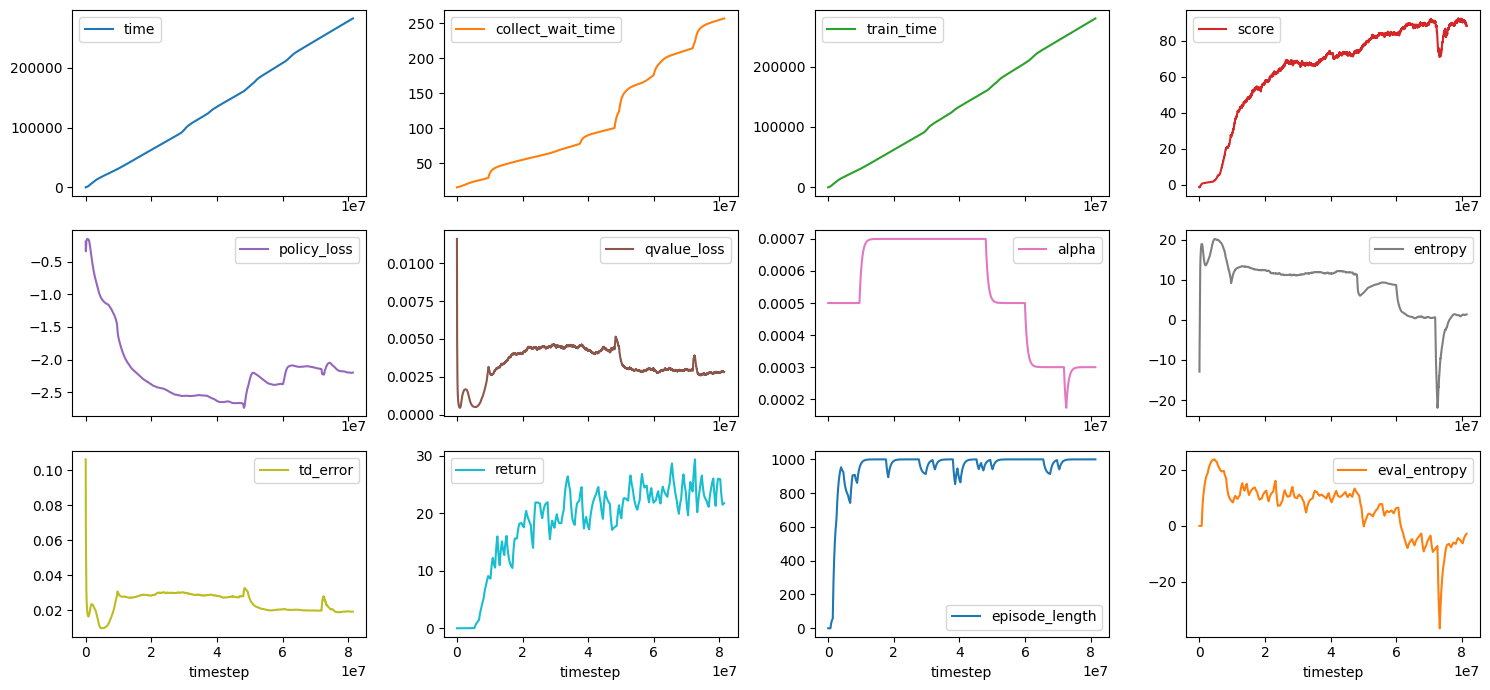

In [121]:
import os
def plot(name, alpha=0):
    # Get dataframe
    logger = Logger(keys = LOG_KEYS, log_path=LOG_PATH, name=name)
    logger.revert()
    df = logger.dataframe()
    df = df.set_index(LOG_INDEX)
    if alpha>0:
        df = df.ewm(alpha=alpha).mean()

    # Plot it
    rows = (len(df.columns) + 3) // 4
    df.plot(subplots=True, layout=(rows,4), figsize=(15, int(rows* 7/3)))
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, f"{name}.png"))
plot("run0", alpha=0.01)

In [116]:
env = create_env(graphics=True, time_scale=1)
env.reset()

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

TensorDict(
    fields={
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        observation: Tensor(shape=torch.Size([10, 243]), device=cpu, dtype=torch.float32, is_shared=False),
        terminated: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([10]),
    device=cpu,
    is_shared=False)

In [117]:
with torch.no_grad():
    data = env.rollout(1000, policy=policy, break_when_any_done=False)

In [70]:
env.close()

In [120]:
SimpleMetricModule(mode="approx")(data)

{'return': 25.069377899169922,
 'episode_length': 1000.0,
 'entropy': -1.6405929327011108}

Default audio device was changed, but the audio system failed to initialize it. Attempting to reset sound system.
Default audio device was changed, but the audio system failed to initialize it. Attempting to reset sound system.
Default audio device was changed, but the audio system failed to initialize it. Attempting to reset sound system.
Default audio device was changed, but the audio system failed to initialize it. Attempting to reset sound system.
Default audio device was changed, but the audio system failed to initialize it. Attempting to reset sound system.
Default audio device was changed, but the audio system failed to initialize it. Attempting to reset sound system.
Default audio device was changed, but the audio system failed to initialize it. Attempting to reset sound system.
Default audio device was changed, but the audio system failed to initialize it. Attempting to reset sound system.
Default audio device was changed, but the audio system failed to initialize it. Attempti